In [1]:
import numpy as np
import matplotlib.pylab as plt

from mpl_toolkits.mplot3d import Axes3D

## 4.3.2 수치 미분의 예
$ y = 0.01 x^2 + 0.1 x$

0.1999999999990898


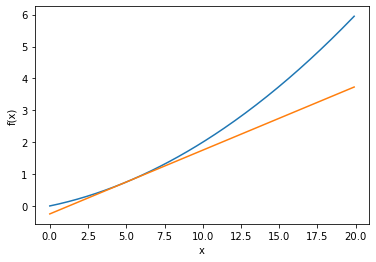

In [2]:
# gradient_1d.py
def function_1(x):
    return 0.01*x**2 + 0.1*x 


def numerical_diff(f, x):
    h = 1e-4 # 0.0001
    return (f(x+h) - f(x-h)) / (2*h)


def tangent_line(f, x):
    d = numerical_diff(f, x)
    print(d)
    y = f(x) - d*x
    return lambda t: d*t + y


x = np.arange(0.0, 20.0, 0.1)
y = function_1(x)
plt.xlabel("x")
plt.ylabel("f(x)")

tf = tangent_line(function_1, 5)
y2 = tf(x)

plt.plot(x, y)
plt.plot(x, y2)

## 4.4 기울기 (gradient)
$ f(x_0,x_1) = x_0^2 + x_1^2$

In [3]:
# gradient_2d.py
def function_2(x):
    if x.ndim == 1:
        return np.sum(x**2)
    else:
        return np.sum(x**2, axis=1)


def _numerical_gradient_no_batch(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x) # x와 형상이 같은 배열을 생성
    
    for idx in range(x.size):
        tmp_val = x[idx]
        
        # f(x+h) 계산
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)
        
        # f(x-h) 계산
        x[idx] = tmp_val - h 
        fxh2 = f(x) 
        
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val # 값 복원
        
    return grad


def numerical_gradient(f, X):
    if X.ndim == 1:
        return _numerical_gradient_no_batch(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_no_batch(f, x)
        
        return grad


def tangent_line(f, x):
    d = numerical_gradient(f, x)
    print(d)
    y = f(x) - d*x
    return lambda t: d*t + y

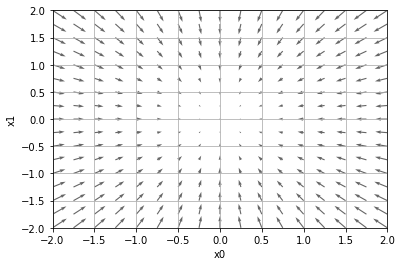

In [4]:
x0 = np.arange(-2, 2.5, 0.25)
x1 = np.arange(-2, 2.5, 0.25)
X, Y = np.meshgrid(x0, x1)

X = X.flatten()
Y = Y.flatten()

grad = numerical_gradient(function_2, np.array([X, Y]) )

plt.figure()
plt.quiver(X, Y, -grad[0], -grad[1],  angles="xy",color="#666666")#,headwidth=10,scale=40,color="#444444")
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.xlabel('x0')
plt.ylabel('x1')
plt.grid()
# plt.legend()
plt.draw()
plt.show()

## 4.4.1 경사법 (경사 하강법)

Text(0, 0.5, 'X1')

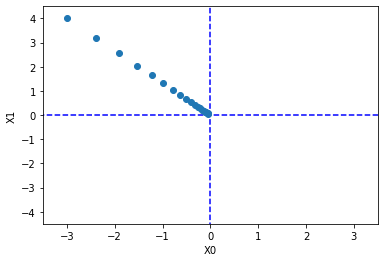

In [5]:
# gradient_method.py
# def function_2(x):
#     return x[0]**2 + x[1]**2

# from gradient_2d import numerical_gradient
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    x_history = []

    for i in range(step_num):
        x_history.append( x.copy() )

        grad = numerical_gradient(f, x)
        x -= lr * grad

    return x, np.array(x_history)


init_x = np.array([-3.0, 4.0])    

lr = 0.1
step_num = 20
x, x_history = gradient_descent(function_2, init_x, lr=lr, step_num=step_num)

plt.plot( [-5, 5], [0,0], '--b')
plt.plot( [0,0], [-5, 5], '--b')
plt.plot(x_history[:,0], x_history[:,1], 'o')

plt.xlim(-3.5, 3.5)
plt.ylim(-4.5, 4.5)
plt.xlabel("X0")
plt.ylabel("X1")

## 4.4.2 신경망에서의 기울기

In [6]:
# gradient_simplenet.py
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
from common.functions import softmax, cross_entropy_error
from common.gradient import numerical_gradient

class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2,3) # 정규분포로 초기화

    def predict(self, x):
        return np.dot(x, self.W)

    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)

        return loss

x = np.array([0.6, 0.9])
t = np.array([0, 0, 1])

net = simpleNet()

f = lambda w: net.loss(x, t)    # w is dummy
dW = numerical_gradient(f, net.W)

print(dW)

[[ 0.47139168  0.11418595 -0.58557763]
 [ 0.70708752  0.17127893 -0.87836645]]


In [7]:
net.loss(x,t)

3.7283141340853163

## 4.5.1 2층 신경망 클래스 구현하기

In [8]:
# two_layer_net.py
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
from common.functions import *
from common.gradient import numerical_gradient


class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
    
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads

In [9]:
# 사용 예
net = TwoLayerNet(input_size=64, hidden_size=20, output_size=5)
net.params

{'W1': array([[ 7.03582998e-03,  1.16788466e-02, -8.61914637e-04, ...,
          1.22168316e-02,  1.62077606e-02,  1.74092458e-02],
        [-7.75997321e-03, -1.13608310e-02,  1.61402867e-03, ...,
          1.27863792e-02, -3.86699825e-03,  5.50848813e-03],
        [ 1.81020722e-02, -1.18319822e-02, -1.35966047e-03, ...,
          1.70560858e-03,  3.44309654e-03, -4.09698315e-04],
        ...,
        [ 1.92098248e-02, -3.79659283e-03,  1.66063190e-02, ...,
         -1.25142364e-02, -5.88882261e-03, -1.68133633e-02],
        [ 2.62449535e-02, -2.25070610e-03,  9.07472374e-04, ...,
          6.55540273e-06,  1.58306325e-03,  3.93286513e-03],
        [-6.44246411e-03,  1.41631227e-02,  2.14373457e-02, ...,
          7.57627443e-03, -2.24030720e-02,  3.79018055e-03]]),
 'b1': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 'W2': array([[ 0.01253486,  0.00720065, -0.00015707,  0.00128197, -0.00330721],
        [-0.00184745, -0.01085487, -0.

<BarContainer object of 5 artists>

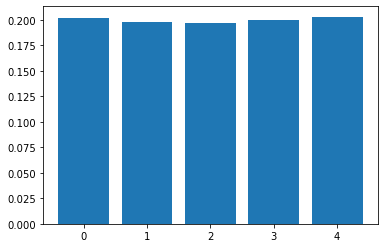

In [10]:
# forward prop
x = np.random.rand(100,64)
y = net.predict(x)

plt.bar(np.arange(0,5), y[0])

In [11]:
# calc numerical gradient
t = np.random.rand(100,5)
numerical_grads = net.numerical_gradient(x, t)
numerical_grads

{'W1': array([[-1.32607398e-04,  6.44020159e-05,  4.80444762e-05, ...,
          2.07192663e-04,  4.49593363e-06, -1.68466467e-04],
        [-1.70525071e-04,  1.15314944e-04,  4.57749350e-05, ...,
          3.60843676e-04, -5.25864396e-05, -2.68370574e-04],
        [-1.71751203e-04,  9.16673260e-05,  2.09654338e-05, ...,
          3.66055762e-04,  6.29005426e-05, -2.38413669e-04],
        ...,
        [-1.47380876e-04,  1.23479519e-04, -1.32490929e-05, ...,
          2.95799267e-04,  4.69671302e-06, -2.27144987e-04],
        [-2.17795433e-04,  2.33049507e-04, -1.04834500e-04, ...,
          4.49058126e-04,  5.32335420e-05, -3.50597968e-04],
        [-2.29149446e-04,  1.61339313e-04, -4.61924388e-05, ...,
          3.87790895e-04,  1.46497990e-04, -2.92833949e-04]]),
 'b1': array([-3.48690700e-04,  2.36368188e-04, -6.33242236e-06,  5.71170796e-04,
        -1.63209556e-04,  7.40598816e-05, -3.96153131e-04, -2.44620088e-04,
        -4.80483728e-04,  6.64461620e-04, -1.43028182e-04, -7.316

In [12]:
grads = net.gradient(x, t)
grads

{'W2': array([[-0.13434763, -0.15463912, -0.14056634, -0.16636266, -0.153337  ],
        [-0.13789885, -0.15787856, -0.14366733, -0.16995344, -0.15682206],
        [-0.14199603, -0.16324548, -0.14857167, -0.17556458, -0.1624851 ],
        [-0.13316857, -0.1531997 , -0.13976647, -0.164807  , -0.15228222],
        [-0.13582627, -0.15605905, -0.14235764, -0.16811238, -0.15530009],
        [-0.13577468, -0.15568656, -0.14200864, -0.16757226, -0.1551328 ],
        [-0.1303766 , -0.14962558, -0.13645406, -0.16103068, -0.1487089 ],
        [-0.13084152, -0.14981155, -0.13670298, -0.16159223, -0.14937616],
        [-0.13333106, -0.15316179, -0.13951172, -0.16444648, -0.15219702],
        [-0.13777201, -0.15787801, -0.14392574, -0.1697955 , -0.15729378],
        [-0.13217486, -0.15166112, -0.13811906, -0.16295259, -0.15092795],
        [-0.13083772, -0.15032799, -0.13701624, -0.16152093, -0.14961827],
        [-0.13785519, -0.15832742, -0.14435066, -0.17040054, -0.15741423],
        [-0.1316758

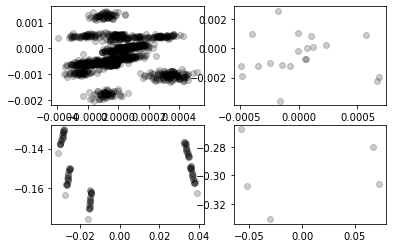

In [13]:
# 비교
plt.subplot(221)
plt.scatter(numerical_grads['W1'], grads['W1'], alpha=0.2, c='k')
plt.subplot(222)
plt.scatter(numerical_grads['b1'], grads['b1'], alpha=0.2, c='k')
plt.subplot(223)
plt.scatter(numerical_grads['W2'], grads['W2'], alpha=0.2, c='k')
plt.subplot(224)
plt.scatter(numerical_grads['b2'], grads['b2'], alpha=0.2, c='k')

## MNIST 데이터로 학습 (4.5.2 미니배치 학습 구현하기 / 4.5.3 시험 데이터로 평가하기)

In [14]:
# train_neuralnet.py
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# 하이퍼파라미터
iters_num = 10000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 100   # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    # grad = network.numerical_gradient(x_batch, t_batch)   # TOO SLOW TO RUN
    grad = network.gradient(x_batch, t_batch)    # faster! (Next chapter)
    
    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

train acc, test acc | 0.09871666666666666, 0.098
train acc, test acc | 0.7871, 0.7939
train acc, test acc | 0.8746666666666667, 0.8795
train acc, test acc | 0.89745, 0.9015
train acc, test acc | 0.9081666666666667, 0.9122
train acc, test acc | 0.9156166666666666, 0.9164
train acc, test acc | 0.91975, 0.921
train acc, test acc | 0.92515, 0.9268
train acc, test acc | 0.9292333333333334, 0.9287
train acc, test acc | 0.9316333333333333, 0.9337
train acc, test acc | 0.93445, 0.9362
train acc, test acc | 0.9368, 0.9374
train acc, test acc | 0.9398666666666666, 0.9408
train acc, test acc | 0.9405166666666667, 0.9415
train acc, test acc | 0.9433, 0.9441
train acc, test acc | 0.9456833333333333, 0.9446
train acc, test acc | 0.9475666666666667, 0.9476


Text(0, 0.5, 'loss')

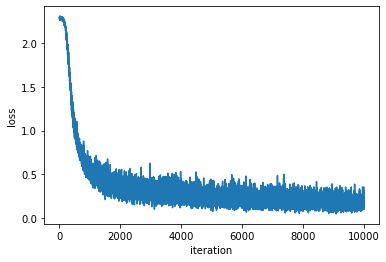

In [15]:
# 손실 함수
plt.plot(train_loss_list)
plt.xlabel('iteration')
plt.ylabel('loss')

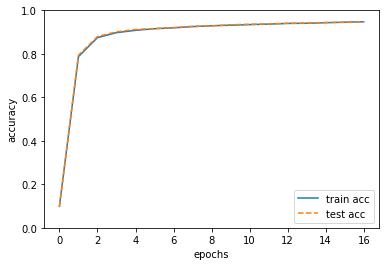

In [16]:
# 정확도 그래프
# markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()